# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

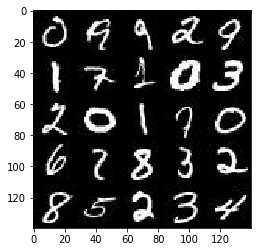

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

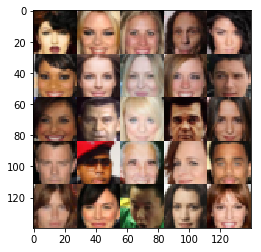

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    # TODO: Implement Function
    ALPHA = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(ALPHA * x1, x1)
        
        # 14x14x64        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(ALPHA * bn2, bn2)
        
        # 7x7x128       
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(ALPHA * bn3, bn3)
        
        # 4x4x256
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        # 7x7x256
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xchannel now

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth=0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    # may cause the error : list index out of range
    
    n_samples, width, height, channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1) 
    
    saver = tf.train.Saver()
    
    #recording training results
    steps = 0
    print_every=20
    show_every=50
    
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # real image in range [-1, 1] tanh
                batch_images *= 2
                
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               input_real: batch_images, 
                                               learn_rate: learning_rate}) 
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

In [24]:
mnist_dataset.shape

(60000, 28, 28, 1)

Epoch 1/2... Discriminator Loss: 0.0665... Generator Loss: 3.4357
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 15.2705


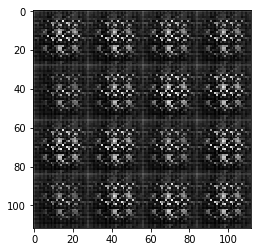

Epoch 1/2... Discriminator Loss: 2.2895... Generator Loss: 0.1151
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 3.9359
Epoch 1/2... Discriminator Loss: 0.2965... Generator Loss: 2.5634


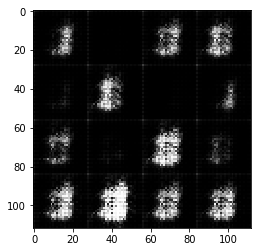

Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 2.1495
Epoch 1/2... Discriminator Loss: 0.1576... Generator Loss: 3.0135


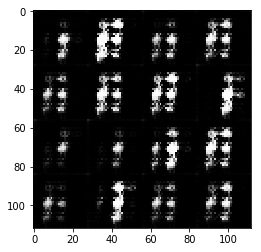

Epoch 1/2... Discriminator Loss: 0.2512... Generator Loss: 2.0466
Epoch 1/2... Discriminator Loss: 0.1644... Generator Loss: 2.6229
Epoch 1/2... Discriminator Loss: 0.2733... Generator Loss: 2.9316


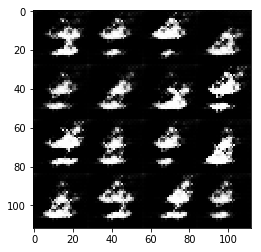

Epoch 1/2... Discriminator Loss: 0.2637... Generator Loss: 2.2008
Epoch 1/2... Discriminator Loss: 0.2608... Generator Loss: 2.9909


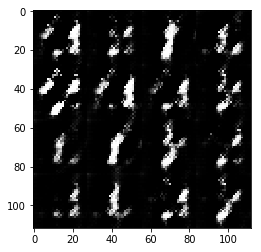

Epoch 1/2... Discriminator Loss: 0.2768... Generator Loss: 5.9345
Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 2.2052
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 2.1099


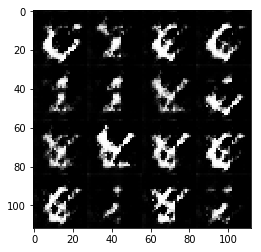

Epoch 1/2... Discriminator Loss: 0.6174... Generator Loss: 6.6405
Epoch 1/2... Discriminator Loss: 0.4191... Generator Loss: 7.3806


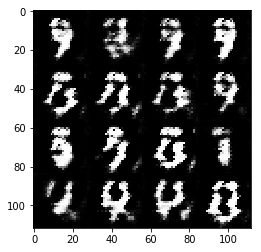

Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 6.4523
Epoch 1/2... Discriminator Loss: 0.7219... Generator Loss: 0.9600
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 1.5467


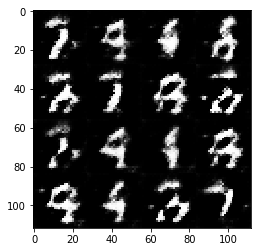

Epoch 1/2... Discriminator Loss: 0.2888... Generator Loss: 4.0779
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.5979


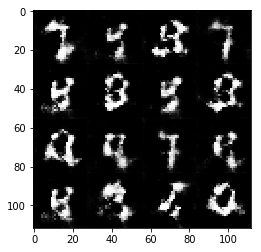

Epoch 1/2... Discriminator Loss: 0.4230... Generator Loss: 2.1257
Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 3.9115
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 1.8467


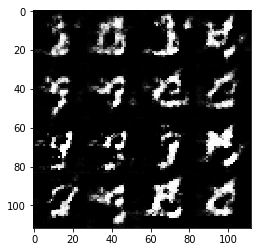

Epoch 1/2... Discriminator Loss: 0.2039... Generator Loss: 3.2820
Epoch 1/2... Discriminator Loss: 0.4471... Generator Loss: 1.8779


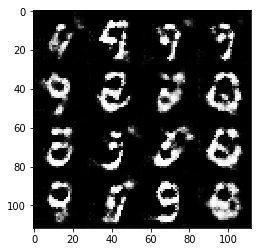

Epoch 1/2... Discriminator Loss: 0.5254... Generator Loss: 1.8031
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.1230
Epoch 1/2... Discriminator Loss: 0.7219... Generator Loss: 1.7371


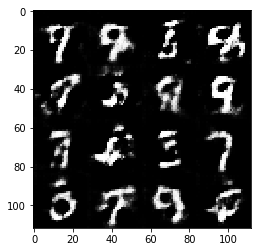

Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 1.6105
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.1182


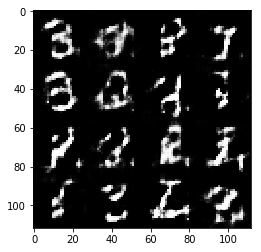

Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 2.8005
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 2.3304


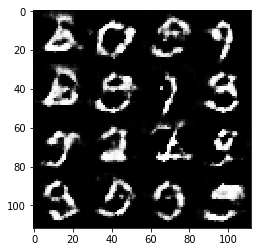

Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 2.1869
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 1.1062


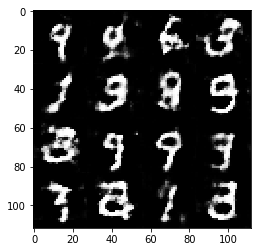

Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.7066
Epoch 1/2... Discriminator Loss: 0.7097... Generator Loss: 1.5503
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 0.7991


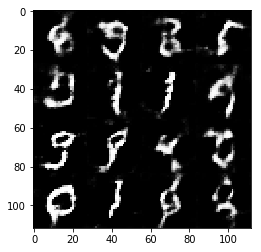

Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 1.8556
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 2.8220


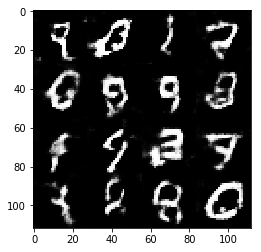

Epoch 1/2... Discriminator Loss: 0.7253... Generator Loss: 1.7064
Epoch 1/2... Discriminator Loss: 0.6464... Generator Loss: 1.2694
Epoch 1/2... Discriminator Loss: 0.7698... Generator Loss: 1.0809


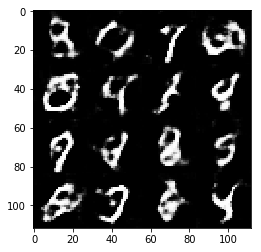

Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 1.5983
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 1.4114


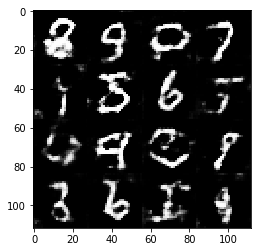

Epoch 2/2... Discriminator Loss: 0.6196... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.3724


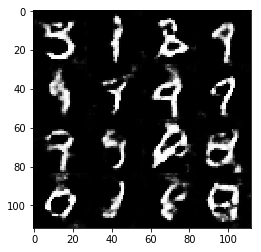

Epoch 2/2... Discriminator Loss: 0.5944... Generator Loss: 1.5699
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.3405


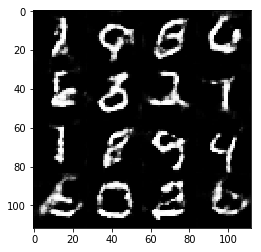

Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 0.7576... Generator Loss: 1.1110
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.4316


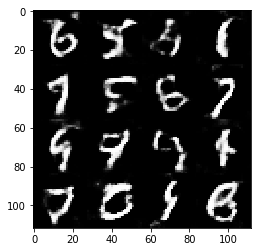

Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 0.6536... Generator Loss: 1.1718


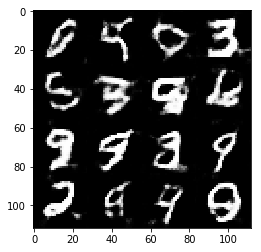

Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 0.6375... Generator Loss: 1.3275
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.0882


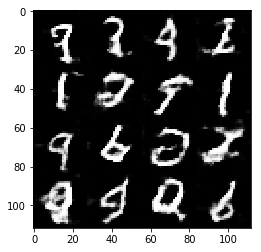

Epoch 2/2... Discriminator Loss: 0.9541... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 0.6611


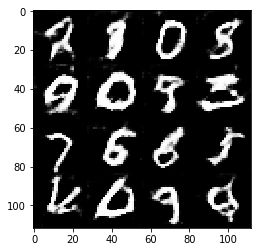

Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 1.7323
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.7197


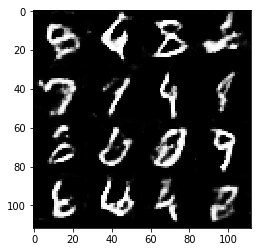

Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 0.6723... Generator Loss: 1.3960


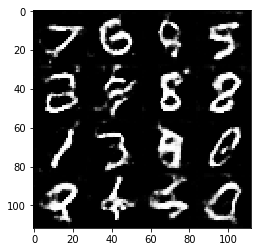

Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.8502
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 1.3320


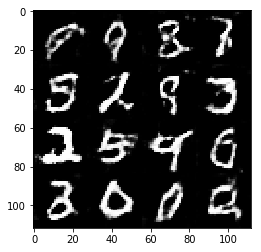

Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 1.7528


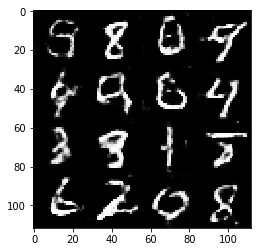

Epoch 2/2... Discriminator Loss: 0.4984... Generator Loss: 1.3740
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 0.6476
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.3341


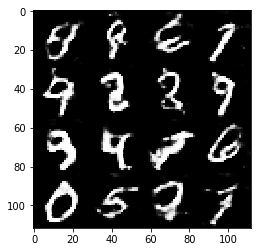

Epoch 2/2... Discriminator Loss: 0.6316... Generator Loss: 1.7915
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 1.6642


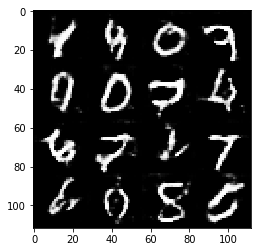

Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 0.7921... Generator Loss: 0.8505


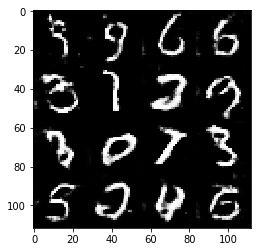

Epoch 2/2... Discriminator Loss: 0.6223... Generator Loss: 1.4743
Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.3564


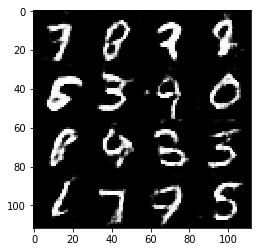

Epoch 2/2... Discriminator Loss: 0.5859... Generator Loss: 1.3709
Epoch 2/2... Discriminator Loss: 0.5909... Generator Loss: 1.3277
Epoch 2/2... Discriminator Loss: 0.6961... Generator Loss: 0.9674


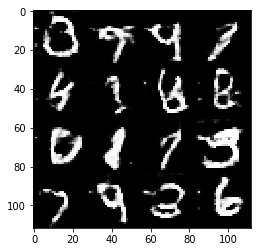

Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 0.8517


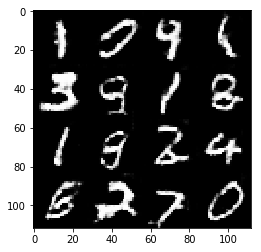

Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 1.7971
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 0.6591


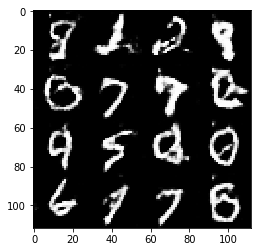

Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 0.5518
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 0.7862


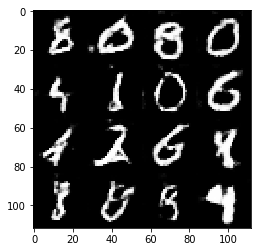

Epoch 2/2... Discriminator Loss: 0.5067... Generator Loss: 1.2991


IndexError: list index out of range

In [25]:
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.3497... Generator Loss: 15.1381
Epoch 1/2... Discriminator Loss: 2.2008... Generator Loss: 0.2170


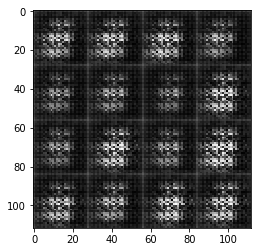

Epoch 1/2... Discriminator Loss: 0.5783... Generator Loss: 1.4513
Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 9.8049
Epoch 1/2... Discriminator Loss: 0.6705... Generator Loss: 1.0716


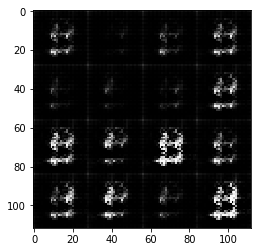

Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 5.8026
Epoch 1/2... Discriminator Loss: 0.0733... Generator Loss: 5.4979


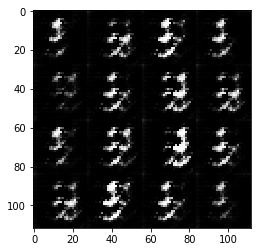

Epoch 1/2... Discriminator Loss: 0.1494... Generator Loss: 3.0445
Epoch 1/2... Discriminator Loss: 0.1616... Generator Loss: 3.6374
Epoch 1/2... Discriminator Loss: 0.1688... Generator Loss: 2.3435


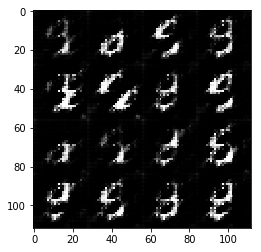

Epoch 1/2... Discriminator Loss: 0.1973... Generator Loss: 3.8120
Epoch 1/2... Discriminator Loss: 0.1934... Generator Loss: 4.1273


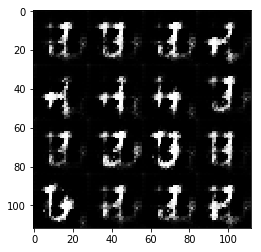

Epoch 1/2... Discriminator Loss: 0.0768... Generator Loss: 3.9164
Epoch 1/2... Discriminator Loss: 0.1318... Generator Loss: 3.5515
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 7.0696


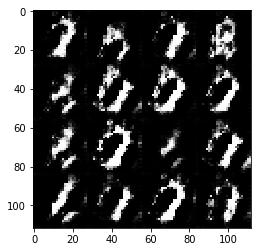

Epoch 1/2... Discriminator Loss: 0.1907... Generator Loss: 3.4767
Epoch 1/2... Discriminator Loss: 0.2131... Generator Loss: 2.8416


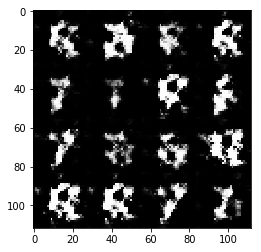

Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 1.2253
Epoch 1/2... Discriminator Loss: 0.1602... Generator Loss: 3.0464
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 1.4740


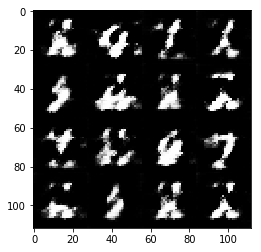

Epoch 1/2... Discriminator Loss: 2.3126... Generator Loss: 8.1919
Epoch 1/2... Discriminator Loss: 0.2297... Generator Loss: 2.5357


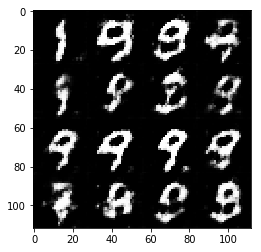

Epoch 1/2... Discriminator Loss: 0.4211... Generator Loss: 2.2221
Epoch 1/2... Discriminator Loss: 0.5413... Generator Loss: 3.0917
Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 4.3882


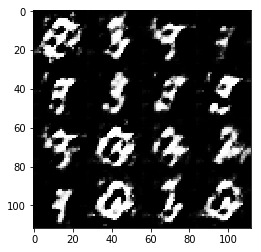

Epoch 1/2... Discriminator Loss: 0.4836... Generator Loss: 1.7990
Epoch 1/2... Discriminator Loss: 0.2838... Generator Loss: 2.6867


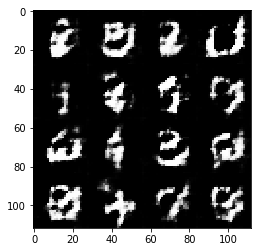

Epoch 1/2... Discriminator Loss: 0.5328... Generator Loss: 2.4575
Epoch 1/2... Discriminator Loss: 0.4812... Generator Loss: 3.1674
Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 1.1624


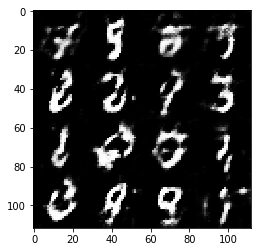

Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 1.1685
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 1.1905


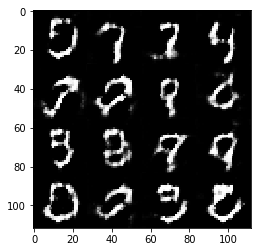

Epoch 1/2... Discriminator Loss: 0.5881... Generator Loss: 1.7144
Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 1.2173
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 1.6933


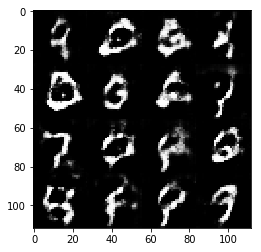

Epoch 1/2... Discriminator Loss: 0.6777... Generator Loss: 1.1931
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 0.8288


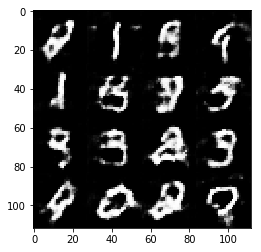

Epoch 1/2... Discriminator Loss: 0.6029... Generator Loss: 1.5901
Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.0481
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.8822


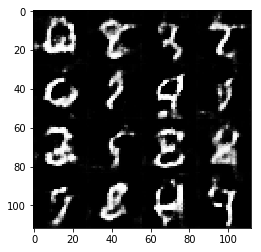

Epoch 1/2... Discriminator Loss: 1.2914... Generator Loss: 3.0150
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 0.8708


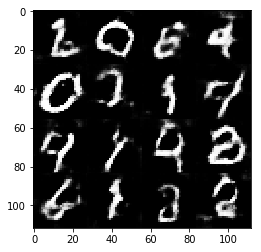

Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 1.6668
Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.7135


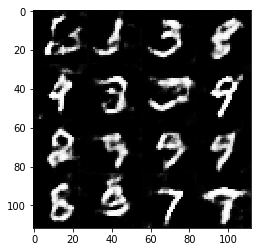

Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 1.4108
Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 1.0549


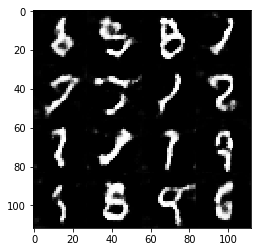

Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 2.5688
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 0.8095


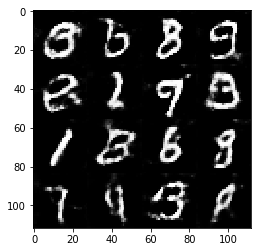

Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 1.0214
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 3.1271


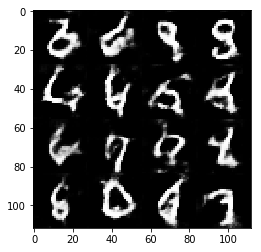

Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 2.1641
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 1.6229


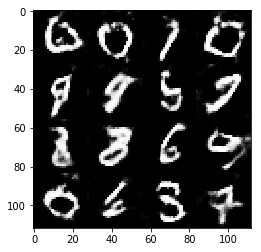

Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.3725
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 0.8599


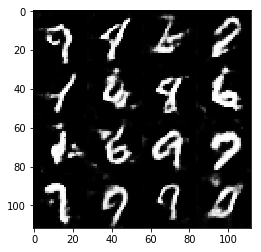

Epoch 2/2... Discriminator Loss: 0.7015... Generator Loss: 1.4882
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 0.7294
Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 1.3149


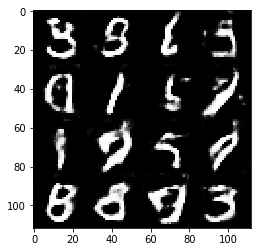

Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.8941
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 1.1054


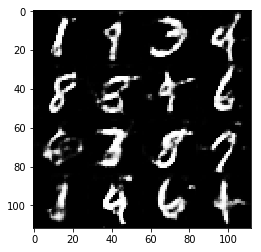

Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.1431
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 1.5883


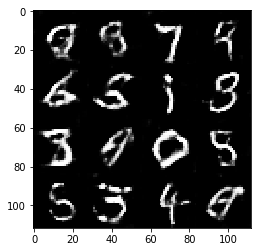

Epoch 2/2... Discriminator Loss: 1.5715... Generator Loss: 2.4920
Epoch 2/2... Discriminator Loss: 0.7300... Generator Loss: 1.0408


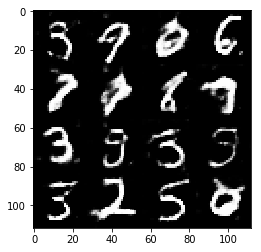

Epoch 2/2... Discriminator Loss: 0.5088... Generator Loss: 1.3730
Epoch 2/2... Discriminator Loss: 0.5310... Generator Loss: 1.4129
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 0.7713


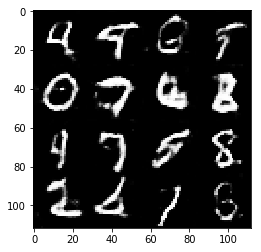

Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 1.4457
Epoch 2/2... Discriminator Loss: 0.5429... Generator Loss: 1.4267


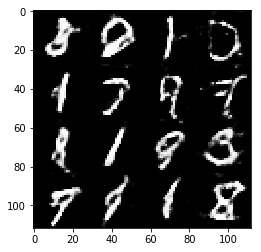

Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 0.9573
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 1.0486


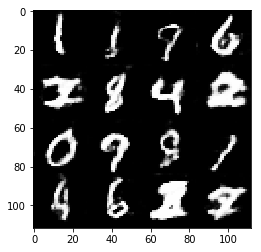

Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 1.5241


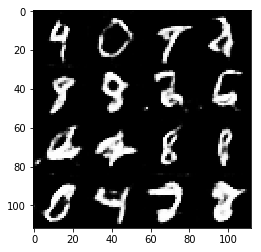

Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 0.6422... Generator Loss: 1.4779
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 0.6768


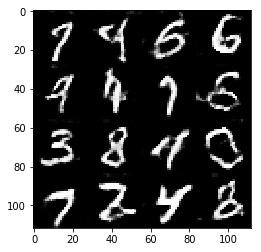

Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 1.3277


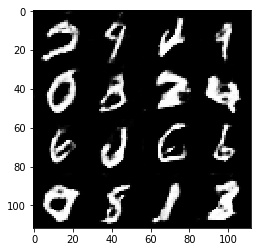

Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 2.0794
Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.1562
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 0.5197


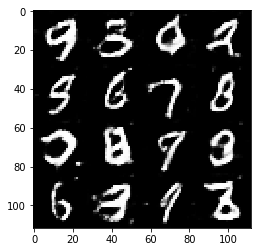

Epoch 2/2... Discriminator Loss: 1.5574... Generator Loss: 0.3182
Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.2342


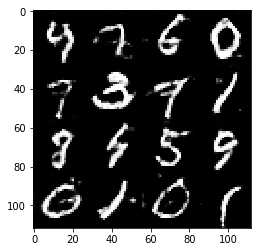

Epoch 2/2... Discriminator Loss: 1.6168... Generator Loss: 0.3557
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 0.9988
Epoch 2/2... Discriminator Loss: 0.6418... Generator Loss: 1.2839


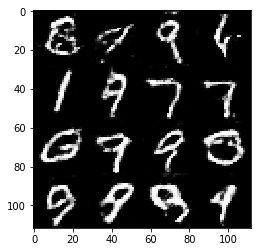

Epoch 2/2... Discriminator Loss: 0.5947... Generator Loss: 1.5019
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 1.2938


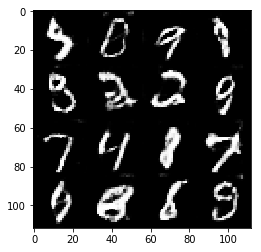

Epoch 2/2... Discriminator Loss: 0.5085... Generator Loss: 1.6439


In [27]:
# without tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 1.6926


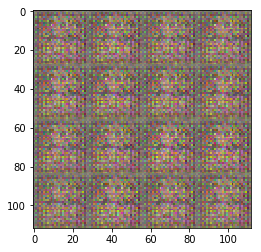

Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 1.9072
Epoch 1/1... Discriminator Loss: 0.2993... Generator Loss: 2.1628
Epoch 1/1... Discriminator Loss: 0.2464... Generator Loss: 2.1635


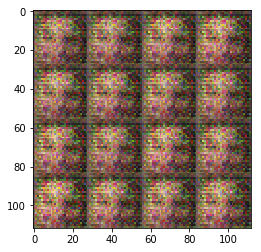

Epoch 1/1... Discriminator Loss: 0.1767... Generator Loss: 2.5510
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 3.3724


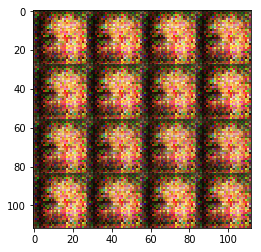

Epoch 1/1... Discriminator Loss: 0.1620... Generator Loss: 2.9013
Epoch 1/1... Discriminator Loss: 0.1339... Generator Loss: 2.8143
Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 2.7297


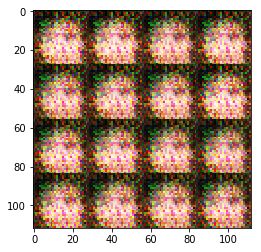

Epoch 1/1... Discriminator Loss: 0.0752... Generator Loss: 3.8336
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 2.3667


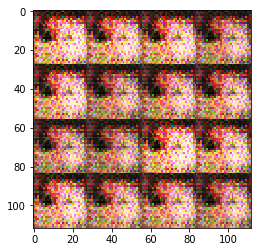

Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.4584
Epoch 1/1... Discriminator Loss: 0.3242... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.2783... Generator Loss: 3.6250


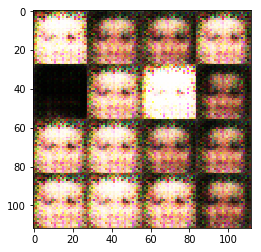

Epoch 1/1... Discriminator Loss: 0.2674... Generator Loss: 2.3394
Epoch 1/1... Discriminator Loss: 0.2699... Generator Loss: 1.8832


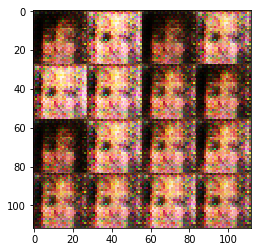

Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 1.7302
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 1.8727
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 3.4320


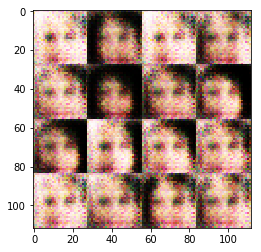

Epoch 1/1... Discriminator Loss: 0.3416... Generator Loss: 2.7933
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 0.9905


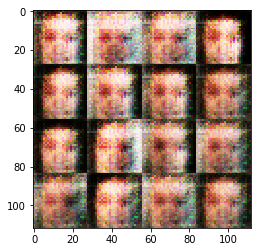

Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.1374
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 2.0299


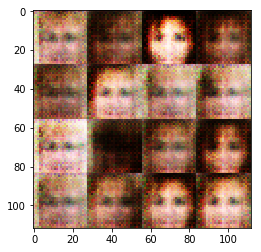

Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.6174
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 1.8062


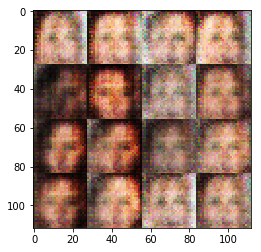

Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 1.7083
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 1.7026


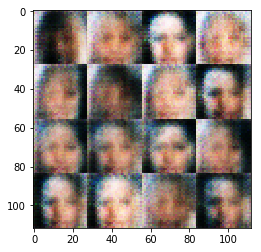

Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.6071


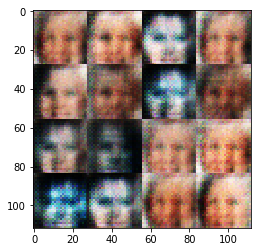

Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 1.9554
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 1.5165
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.6093


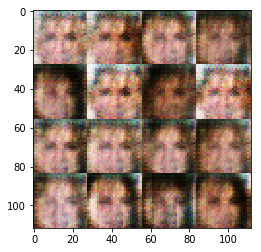

Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.2778


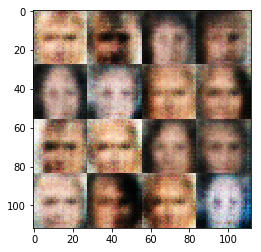

Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.5737


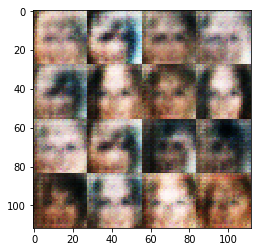

Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.5529


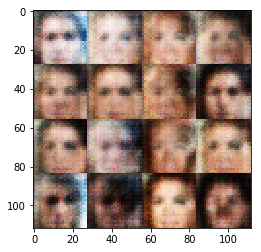

Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.4332


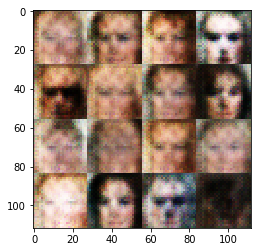

Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.7600


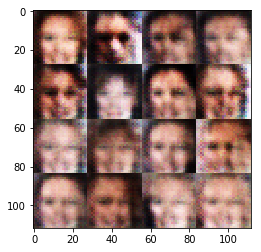

Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.9338


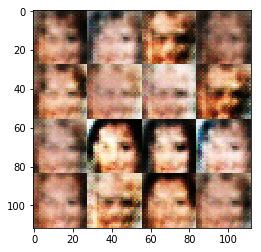

Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.6203


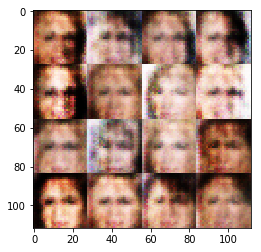

Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.8571


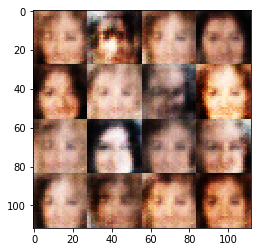

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.2794


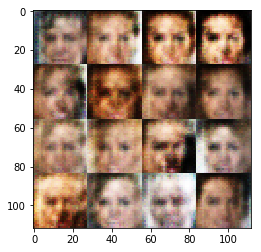

Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.8256


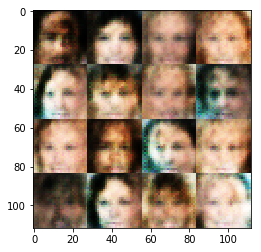

Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.3867


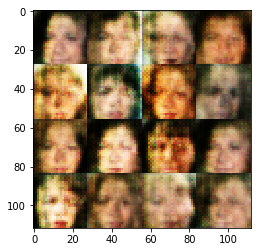

Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.4484


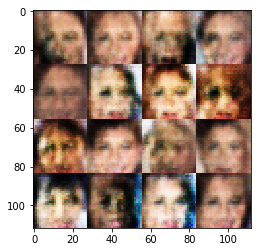

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.8132


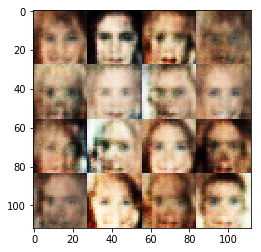

Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.2776
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.3738


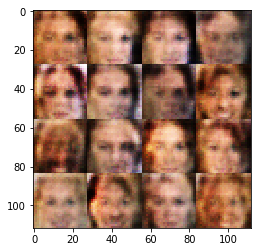

Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.4381
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.4137


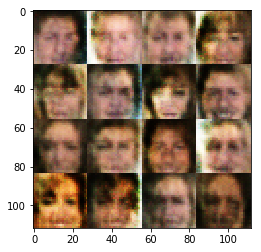

Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.6098


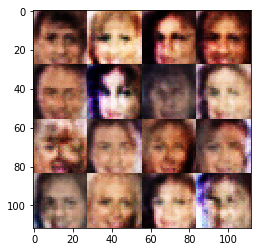

Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.1556


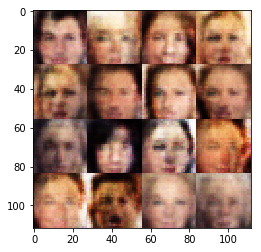

Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 1.0618


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.